In [1]:
# check the distribution of MO-ASMO objective functions

In [2]:
import numpy as np
import os, glob, sys, toml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

if __name__ == '__main__':

    basinnum = 627
    nmet = 22
    # nmet = 19
    metrics = np.nan * np.zeros([basinnum, 400, nmet])
    
    for basin in range(basinnum):
        if np.mod(basin, 50)==0:
            print('basin', basin)
                   
        configfile = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO/configuration/_level1-{basin}_config_MOASMO.toml'
        config = toml.load(configfile)
        iterflag = 0
    
        for trialflag in range(400):
        
            if config['path_calib'] == 'NA':
                path_MOASMOcalib = f'{path_CTSM_base}_MOASMOcalib'
            else:
                path_MOASMOcalib = config['path_calib']
            path_archive = f'{path_MOASMOcalib}/ctsm_outputs'
            caseflag = f'iter{iterflag}_trial{trialflag}'
            outfile_metric = f'{path_archive}/{caseflag}/evaluation_many_metrics.csv'

            if os.path.isfile(outfile_metric):
                try:
                    df = pd.read_csv(outfile_metric)
                    metrics[basin, trialflag, :] = df.values[0]
                except:
                    print('failed reading')


metnames = df.columns.values
# for m in ['kge', 'cc', 'nse']:
for m in ['kge', 'cc', 'nse', 'kge_log_q', 'kge_summer', 'kge_winter', 'kge_spring', 'kge_autumn']:
    ind1 = np.where(metnames==m)[0][0]
    metrics[:,:,ind1] = 1 - metrics[:,:,ind1] # minimize values
    metnames[ind1] = '1-'+m

print('metric names', metnames)

basin 0
failed reading
basin 50
basin 100
basin 150
failed reading
failed reading
failed reading
basin 200
basin 250
basin 300
basin 350
basin 400
basin 450
basin 500
basin 550
basin 600
metric names ['1-kge' 'mae' '1-nse' '1-cc' 'rmse' 'max_mon_abs_err' 'q90_mae' 'q10_mae'
 'q90_days_err' 'q10_days_err' '1-kge_log_q' '1-kge_summer' '1-kge_winter'
 '1-kge_spring' '1-kge_autumn' 'mae_summer' 'mae_winter' 'mae_spring'
 'mae_autumn' 'ge_q25_mae' 'ge_q50_mae' 'ge_q75_mae']


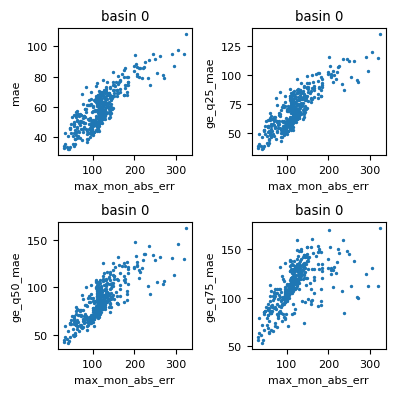

In [13]:
# np.savez_compressed('all_basin_metric.npz', metrics=metrics, metnames=metnames)

met1 = 'max_mon_abs_err'
met2 = ['mae', 'ge_q25_mae', 'ge_q50_mae', 'ge_q75_mae']
ind1 = np.where(metnames == met1)[0][0]


font = {'size': 8}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[4, 4])

for b in range(1):
    flag = 1
    for j in range(len(met2)):
        ax = fig.add_subplot(2, 2, flag)
        data1 = metrics[b, :, ind1]

        ind2 = np.where(metnames == met2[j])[0][0]
        data2 = metrics[b, :, ind2]
        ax.scatter(data1, data2, 2)
        ax.set_xlabel(met1)
        ax.set_ylabel(met2[j])
        ax.set_title(f'basin {b}')

        flag = flag + 1

plt.tight_layout()

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Assuming 'metrics' and 'metnames' are defined and loaded with your data

met1 = 'max_mon_abs_err'
met2 = ['mae', 'ge_q25_mae', 'ge_q50_mae', 'ge_q75_mae']

font = {'size': 8}
matplotlib.rc('font', **font)

# Create a PDF file to save the plots
with PdfPages('all_camels_basins.pdf') as pdf:
    for b in range(basinnum): # Replace your_basin_count with the number of basins
        fig = plt.figure(figsize=[4, 4])
        flag = 1
        for j in range(len(met2)):
            ax = fig.add_subplot(2, 2, flag)
            ind1 = np.where(metnames == met1)[0][0]
            data1 = metrics[b, :, ind1]
            
            ind2 = np.where(metnames == met2[j])[0][0]
            data2 = metrics[b, :, ind2]
            ax.scatter(data1, data2, 2)
            ax.set_xlabel(met1)
            ax.set_ylabel(met2[j])
            ax.set_title(f'basin {b}')
            
            flag += 1

        plt.tight_layout()
        pdf.savefig(fig)  # Save the current figure into the PDF
        plt.close(fig)  # Close the figure to free memory


In [24]:
met1 = 'max_mon_abs_err'
met2 = ['mae', 'ge_q25_mae', 'ge_q50_mae', 'ge_q75_mae']
ind1 = np.where(metnames == met1)[0][0]

cc = np.nan * np.zeros([basinnum, len(met2)])

for b in range(basinnum):
    for j in range(len(met2)):
        data1 = metrics[b, :, ind1]

        ind2 = np.where(metnames == met2[j])[0][0]
        data2 = metrics[b, :, ind2]

        ind = ~np.isnan(data1+data2)

        cci = np.corrcoef(data1[ind], data2[ind])
        cc[b, j] = cci[0, 1]

        

In [28]:
np.nanmean(cc, axis=0), np.nanmedian(cc, axis=0)

(array([0.59292875, 0.62324105, 0.64557662, 0.64097088]),
 array([0.66626656, 0.69079158, 0.71236406, 0.68588264]))

In [87]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.model_selection import KFold
import numpy as np

def train_and_evaluate_with_predictions_gpr(params, metrics_use):
    print('Processing...')

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    kge_scores = []  # To store the KGE score for each fold

    # Define the kernel with Matern function
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    
    # Initialize the GPR model
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)

    for train_idx, test_idx in cv.split(params):
        X_train, X_test = params[train_idx], params[test_idx]
        y_train, y_test = metrics_use[train_idx], metrics_use[test_idx]

        # Normalize features
        scaler = MinMaxScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)  # Fit the model on the training data
        y_pred = model.predict(X_test_scaled)  # Predict on the test set

        # Calculate KGE for each column (target) and take the mean
        fold_kge_scores = [get_modified_KGE(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
        fold_mean_kge = np.nanmean(fold_kge_scores)  # Compute the mean KGE score for this fold, ignoring any NaN values
        kge_scores.append(fold_mean_kge)

    mean_kge_score = np.mean(kge_scores)  # Calculate the mean KGE score across all folds

    return mean_kge_score

# Execute the function with your data
mean_kge_score_gpr = train_and_evaluate_with_predictions_gpr(params, metrics_use)
print('Mean KGE score for GPR:', mean_kge_score_gpr)

# Optionally, save the results
# np.savez_compressed(f'cv_scores_gpr_{basin}.npz', mean_kge_score=mean_kge_score_gpr)


Processing...
Mean KGE score for GPR: 0.7538556566419581
